In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_NN(nn.Module):
    def __init__(self, K_no, L_no, H_no, T_no, device):
        super().__init__()
        
        self.K_no = K_no
        self.L_no = L_no
        self.H_no = H_no
        self.T_no = T_no
        self.device = device
        
        nn_list = []
        for l in range(self.L_no):
            if l == 0:
                nn_list.append(nn.Conv1d(in_channels=2, out_channels=H_no, kernel_size=K_no, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
            elif l == self.L_no - 1:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=1, kernel_size=1, padding=0))
            else:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=H_no, kernel_size=1, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
        
        self.nn = nn.Sequential(*nn_list)
        
        self.cos_basis_no = 30
        self.scale = 7.5
        self.shift = 1
        self.kern_basis = torch.zeros(self.cos_basis_no, T_no).to(device)
        for i in range(self.cos_basis_no):
            phi = 1.5707963267948966*i
            xmin = phi - 3.141592653589793
            xmax = phi + 3.141592653589793

            x_in = torch.arange(0, T_no, 1)
            raw_cos = self.scale  * torch.log(x_in + self.shift + 1e-7)

            basis = 0.5*torch.cos(raw_cos - phi) + 0.5
            basis[raw_cos < xmin] = 0.0
            basis[raw_cos > xmax] = 0.0
            self.kern_basis[i] = basis
        self.W_refract = nn.Parameter(torch.randn(self.cos_basis_no)*0.01)
        
    def train_forward(self, V, D, S):
        #V, D, S is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        S_pad = torch.zeros(S.shape[0], 1, S.shape[1] + self.T_no-1).to(self.device)
        S_pad[:, 0, -S.shape[1]:] = S_pad[:, 0, -S.shape[1]:] + S
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        S_conv = F.conv1d(S_pad, refract_kern.reshape(1,1,-1)).squeeze(1)
        
        P = torch.sigmoid(nn_out + S_conv)
        return P
    
    def test_forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        refract_kern = torch.flip(torch.matmul(self.kern_basis.T, self.W_refract), [0]) #(T_no)
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        
        S_out_pad = torch.zeros(V.shape[0], V.shape[1] + self.T_no).to(self.device)
        P_out = torch.zeros(V.shape[0], V.shape[1]).to(self.device)
        
        for t in range(V.shape[1]):
            nn_t = nn_out[:,t].clone() #(batch)
            refract_t = torch.sum(S_out_pad[:,t:t+self.T_no].clone() * refract_kern.reshape(1,-1) , 1) #(batch)
            P_t = torch.sigmoid(nn_t + refract_t)
            S_out_pad[:,self.T_no+t] = S_out_pad[:,self.T_no+t] + torch.bernoulli(P_t)
            P_out[:,t] = P_out[:,t] + P_t
        
        S_out = S_out_pad[:,self.T_no:]
        return S_out, P_out



In [3]:
batch_size = 5
batch_length = 50000
K_no = 1
L_no = 2
H_no = 20
T_no = 501
device = torch.device("cuda")

epoch_no = 100
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred.npy").flatten()
D = np.zeros((V.shape[0]))
D[:-1] = np.diff(V)
#D = V.copy()
D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_NN(K_no, L_no, H_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

111


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model.test_forward(batch_V, batch_D)
    #batch_P = model.train_forward(batch_V, batch_D, batch_S)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out, P_test = model.test_forward(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-0bb8ea78a585>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 3.968844175338745 11.741902589797974
49 0.21069130301475525 11.514561653137207
99 0.16463318467140198 11.76706576347351
149 0.137567400932312 11.907082557678223
199 0.11972232908010483 12.154505252838135
249 0.10623878985643387 12.329416513442993
299 0.09443661570549011 12.177319765090942
349 0.0858876183629036 11.957801818847656
399 0.07800249010324478 11.863227128982544
449 0.07069950550794601 12.12735366821289
499 0.06472206860780716 11.905217409133911
549 0.05897210165858269 12.401768207550049
599 0.05407917872071266 12.187415361404419
649 0.04972364008426666 11.80048394203186
699 0.04509451240301132 12.326048612594604
749 0.04129864275455475 12.013504266738892
799 0.03764045983552933 11.997360229492188
849 0.03409597650170326 11.948017358779907
899 0.031031060963869095 11.856309652328491
949 0.028222840279340744 12.210047245025635
999 0.025762371718883514 11.95114517211914
1049 0.023335633799433708 12.074995279312134
1099 0.021422432735562325 11.878858804702759
1149 0.0195565726

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2849 0.006137683056294918 11.932565212249756
2899 0.006054421421140432 12.22451400756836
2949 0.005973384249955416 12.086410522460938
2999 0.005895501002669334 11.81776762008667
3049 0.005819998681545258 12.241919755935669
3099 0.005743364337831736 11.79019808769226
3149 0.005666273180395365 11.824287414550781
3199 0.005590352229773998 11.823102474212646
3249 0.0055124289356172085 12.407118082046509
3299 0.005444358568638563 11.868498086929321
3349 0.005370005965232849 12.30112624168396
3399 0.005292859859764576 12.456624269485474
3449 0.005219427868723869 11.779123067855835
3499 0.005146080628037453 11.99294662475586
3549 0.005073107313364744 12.35074496269226
3599 0.004999170545488596 11.800252437591553
3649 0.004928955342620611 11.922362804412842
3699 0.004857879597693682 12.335243701934814
3749 0.004782919771969318 11.919750452041626
3799 0.0047121369279921055 12.547306060791016
3849 0.0046373819932341576 11.795273065567017
3899 0.004562561400234699 12.224626302719116
3949 0.004489

KeyboardInterrupt: 

In [ ]:
# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

tensor(0.0228, device='cuda:0', grad_fn=<MaxBackward1>)


(0.0, 0.25)

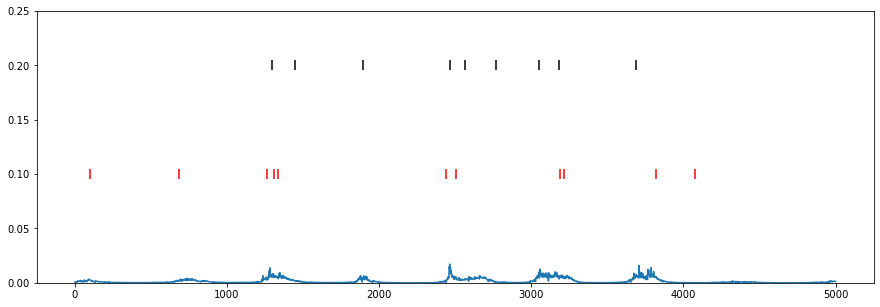

In [7]:
plt.figure(figsize = (15,5))
plt.plot(P_test[0][10000:15000].cpu().detach().numpy()[:])
plt.scatter(np.arange(5000), S_test[0][12000:32000][10000:15000].cpu().detach().numpy()-0.8, s=100, color="black", marker="|")
plt.scatter(np.arange(5000), test_S_out[0][10000:15000].cpu().detach().numpy()*0.9-0.8, s=100, color="red", marker="|")
print(torch.max(P_test))
plt.ylim(0,0.25)